# **Population-Level Sleep Pattern Analysis for Public Health**
## **Objective:**
to study how people’s sleep habits are different based on their age, gender, or lifestyle, and how sleep is connected to health problems like depression, obesity, and diabetes.

## **Dataset**

## **Import libraries**

In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob

## **Loading the datasets**

### Dataset overview

The dataset used in this study comes from the **Sleep Heart Health Study (SHHS)**, a large-scale, community-based cohort study investigating the relationship between sleep-disordered breathing and cardiovascular outcomes.  
The dataset contains **polysomnography (PSG)** recordings and accompanying demographic information.

#### Polysomnography Data
Each PSG file records multiple physiological signals collected overnight during sleep.  
The main signal channels include:
- **EEG** (Electroencephalogram): Brain electrical activity, used to determine sleep stages.
- **EOG (L/R)** (Electrooculogram): Eye movement, useful for detecting REM sleep.
- **EMG** (Electromyogram): Muscle activity, especially chin and leg movements.
- **ECG** (Electrocardiogram): Heart electrical activity.
- **SaO₂** (Oxygen saturation): Blood oxygen level from pulse oximetry.
- **PR** (Pulse rate): Heart rate derived from the oximeter.
- **Airflow**: Measures breathing through the nose and mouth.
- **Thoracic/Abdominal respiratory effort (THOR RES)**: Measures breathing effort.

#### Hypnogram Data
Each PSG recording has a matching **hypnogram** file containing annotations for sleep stages:
- Wake
- N1 (Light sleep)
- N2 (Intermediate sleep)
- N3 (Deep sleep / Slow-wave sleep)
- REM (Rapid Eye Movement sleep)

These annotations allow calculation of key sleep metrics such as:
- **TST**: Total Sleep Time
- **TIB**: Time in Bed
- **Sleep Efficiency**: Percentage of time in bed spent asleep

#### Demographic Data
For each participant, demographic variables include:
- **Age**
- **Sex**
- **LightsOff time** (bedtime, used for chronotype analysis)

In this project, demographic data was merged with PSG-derived sleep metrics for analysis of sleep patterns by age and gender.


- [Sleep-EDF](https://physionet.org/content/sleep-edfx/1.0.0/)
- [Sleep Heart Health Study](https://sleepdata.org/datasets/shhs)

Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/0000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8099749  =      0.000 ... 32398.996 secs...


/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_10407/4254567270.py:2: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_10407/4254567270.py:2: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


<Info | 8 non-empty values
 bads: []
 ch_names: SaO2, PR, EEG(sec), ECG, EMG, EOG(L), EOG(R), EEG, AIRFLOW, THOR ...
 chs: 11 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 11
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: 0000>
>
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using matplotlib as 2D backend.


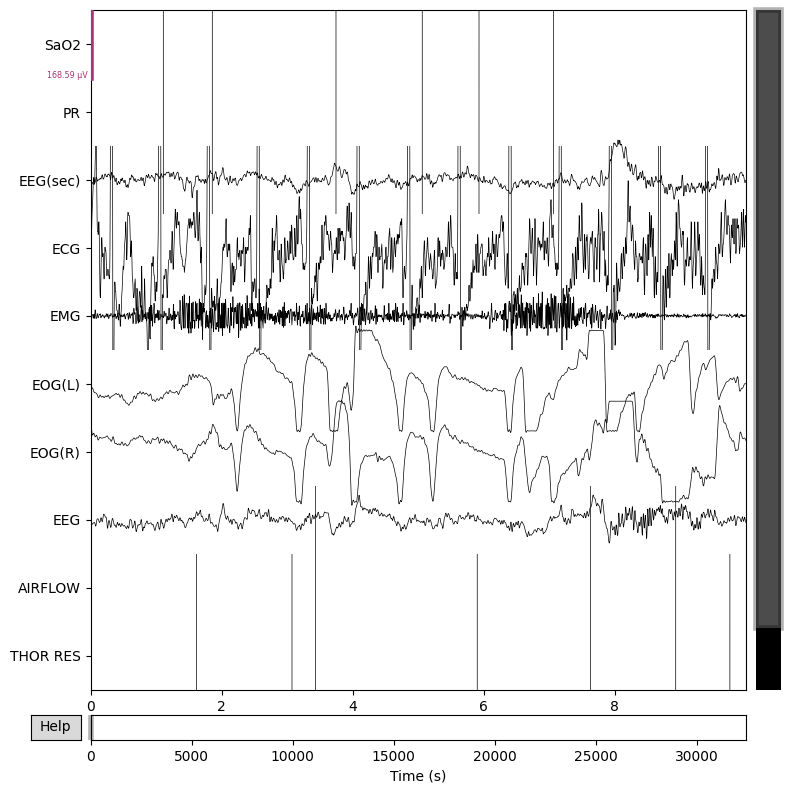

In [76]:
edf_file = './data/0000.edf'
raw = mne.io.read_raw_edf(edf_file, preload=True)
print(raw.info)

raw.pick_types(eeg=True)
raw.plot(duration=10, n_channels=10, scalings='auto', title='EEG Raw Data')
plt.show()

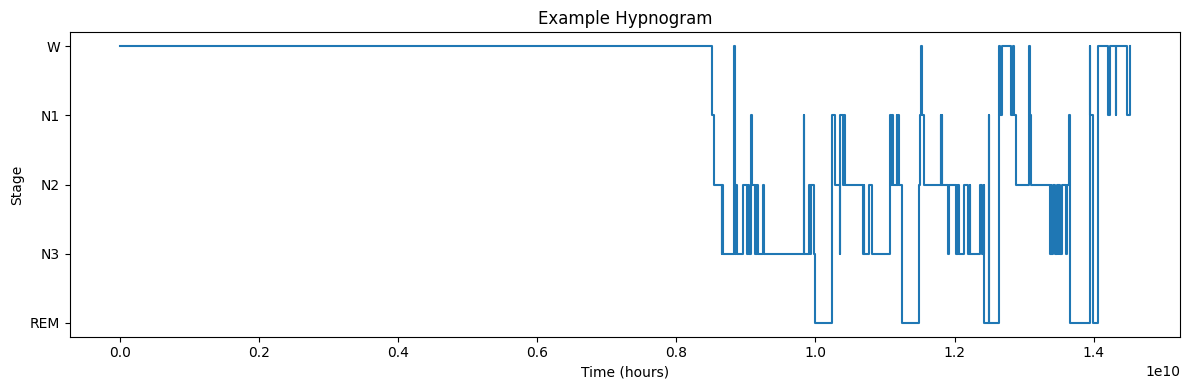

In [83]:
import mne
import matplotlib.pyplot as plt
import pandas as pd

# Load hypnogram annotations
hyp_file = './data/sleep-cassette/SC4001EC-Hypnogram.edf'
annotations = mne.read_annotations(hyp_file)

# Convert annotations to DataFrame
df = annotations.to_data_frame()

# Ensure onset is numeric (seconds from start)
df['onset'] = pd.to_numeric(df['onset'], errors='coerce')

# Map stage names to numeric codes
stage_map = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,  # merge 3 and 4
    'Sleep stage R': 4
}
df['stage_code'] = df['description'].map(stage_map)

# Drop any rows with NaN onset or stage_code
df = df.dropna(subset=['onset', 'stage_code'])

# Plot hypnogram
plt.figure(figsize=(12, 4))
plt.step(df['onset'] / 3600, df['stage_code'], where='post')
plt.yticks([0, 1, 2, 3, 4], ['W', 'N1', 'N2', 'N3', 'REM'])
plt.xlabel('Time (hours)')
plt.ylabel('Stage')
plt.title('Example Hypnogram')
plt.gca().invert_yaxis()  # Conventional hypnogram format
plt.tight_layout()
plt.show()


# Sleep Study: Data Wrangling Pipeline

## 1) Inputs
- **PSG metrics**: `results_df` with columns  
  `['subject_id', 'TST_minutes', 'Time_in_Bed_minutes', 'Sleep_Efficiency_%']`
- **Demographics**: Excel `SC-subjects.xlsx` with columns  
  `['subject', 'night', 'age', 'sex', 'LightsOff']` (two nights per subject)

## 2) Goals
- Keep **one night per subject** (night 1).
- Create a common key **subject_base** = `SC####` (ignore suffix like E0/EC).
- Merge demographics with PSG metrics.
- Convert `LightsOff` to `LightsOff_hour`.
- Drop unneeded columns and validate ranges.

## 3) Steps
1. Build `subject_base` from PSG (`subject_id.str[:6]`).
2. Load demographics and **filter to night==1**.
3. Map numeric `subject` (0,1,2,...) to available bases by **order**.
4. Merge on `subject_base`.
5. Create `LightsOff_hour`.
6. Select clean columns, drop nulls, and sanity‑check values.

## 4) Outputs
- **merged** with columns:  
  `[subject_base, age, sex, LightsOff_hour, TST_minutes, Time_in_Bed_minutes, Sleep_Efficiency_%]`


In [3]:
import os, glob
import mne
import pandas as pd
import numpy as np

data_folder = 'data/sleep-cassette/'
psg_files = [f for f in os.listdir(data_folder) if '-PSG.edf' in f]
results = []

# Labels you may see in SHHS hypnograms
ALL_STAGES = {'Sleep stage W','Sleep stage 1','Sleep stage 2','Sleep stage 3','Sleep stage 4','Sleep stage R'}
SLEEP_ONLY  = {'Sleep stage 1','Sleep stage 2','Sleep stage 3','Sleep stage 4','Sleep stage R'}  # exclude Wake

for psg_file in psg_files:
    subject_id = psg_file.split('-')[0]     # e.g., SC4001E0
    subject_prefix = subject_id[:-2]        # e.g., SC4001

    # find matching hypnogram (EC/EH/EJ/EP etc.)
    hypnogram_pattern = os.path.join(data_folder, subject_prefix + 'E*-Hypnogram.edf')
    matches = glob.glob(hypnogram_pattern)
    if not matches:
        print(f"Skipping {psg_file}: No Hypnogram file found.")
        continue
    hypnogram_file = os.path.basename(matches[0])

    psg_path = os.path.join(data_folder, psg_file)
    hyp_path = os.path.join(data_folder, hypnogram_file)
    print(f"Processing {psg_file}  |  Hypnogram: {hypnogram_file}")

    raw = mne.io.read_raw_edf(psg_path, preload=False)
    ann = mne.read_annotations(hyp_path)
    raw.set_annotations(ann)

    onsets = np.array(raw.annotations.onset)      # seconds from recording start
    durs   = np.array(raw.annotations.duration)   # seconds
    descs  = np.array(raw.annotations.description)

    # ---- define the TIB window (first to last *scored* stage, incl. Wake) ----
    sleep_mask = np.isin(descs, list(SLEEP_ONLY))
    if not sleep_mask.any():
        print(f"Skipping {subject_id}: no sleep stages found.")
        continue
    
    first_sleep_idx = np.where(sleep_mask)[0][0]
    last_sleep_idx  = np.where(sleep_mask)[0][-1]
    
    tib_start = onsets[first_sleep_idx]
    tib_end   = onsets[last_sleep_idx] + durs[last_sleep_idx]
    TIB_minutes = (tib_end - tib_start) / 60.0
    # ---- Total Sleep Time (sum of sleep stages only; exclude Wake) ----
    sleep_mask = np.isin(descs, list(SLEEP_ONLY))
    TST_minutes = float((durs[sleep_mask].sum()) / 60.0)

    # ---- Metrics ----
    Sleep_Efficiency = (TST_minutes / TIB_minutes) * 100 if TIB_minutes > 0 else np.nan

    results.append({
        'subject_id': subject_id,
        'TST_minutes': round(TST_minutes, 1),
        'Time_in_Bed_minutes': round(TIB_minutes, 1),
        'Sleep_Efficiency_%': round(Sleep_Efficiency, 2)
    })

results_df = pd.DataFrame(results)
print(results_df.head())


Processing SC4201E0-PSG.edf  |  Hypnogram: SC4201EC-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4201E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4171E0-PSG.edf  |  Hypnogram: SC4171EU-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4171E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Skipping SC4272F0-PSG.edf: No Hypnogram file found.
Processing SC4421E0-PSG.edf  |  Hypnogram: SC4421EA-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4421E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:32: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(ann)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/172627504

Processing SC4751E0-PSG.edf  |  Hypnogram: SC4751EC-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4751E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Skipping SC4452F0-PSG.edf: No Hypnogram file found.
Processing SC4622E0-PSG.edf  |  Hypnogram: SC4622EJ-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4622E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Skipping SC4592G0-PSG.edf: No Hypnogram file found.
Processing SC4002E0-PSG.edf  |  Hypnogram: SC4002EC-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4112E0-PSG.edf  |  Hypnogram: SC4112EC-Hypnogram.edf
Extracting EDF parameters from /Users/

/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:32: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(ann)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/172627504

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4082E0-PSG.edf  |  Hypnogram: SC4082EP-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4082E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4611E0-PSG.edf  |  Hypnogram: SC4611EG-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4611E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Skipping SC4381F0-PSG.edf: No Hypnogram file found.
Processing SC4031E0-PSG.edf  |  Hypnogram: SC4031EC-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Skipping SC4332F0-PSG.edf: No Hypnogram file found.
Processing SC4121E0-P

/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:32: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(ann)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/172627504

Processing SC4022E0-PSG.edf  |  Hypnogram: SC4022EJ-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4022E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4151E0-PSG.edf  |  Hypnogram: SC4151EC-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4151E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4221E0-PSG.edf  |  Hypnogram: SC4221EJ-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4221E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4401E0-PSG.edf  |  Hypnogram: SC4401EC-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4401E0-PSG.edf...
EDF file detected
Setting c

/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:32: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(ann)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/172627504

Skipping SC4551F0-PSG.edf: No Hypnogram file found.
Processing SC4302E0-PSG.edf  |  Hypnogram: SC4302EV-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4302E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4072E0-PSG.edf  |  Hypnogram: SC4072EH-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4072E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Skipping SC4371F0-PSG.edf: No Hypnogram file found.
Skipping SC4491G0-PSG.edf: No Hypnogram file found.
Processing SC4101E0-PSG.edf  |  Hypnogram: SC4101EC-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4101E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4721E0-PSG.edf  |  Hypnogram: SC4721EC-

/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:32: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(ann)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/172627504

Skipping SC4341F0-PSG.edf: No Hypnogram file found.
Processing SC4211E0-PSG.edf  |  Hypnogram: SC4211EC-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4211E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4161E0-PSG.edf  |  Hypnogram: SC4161EC-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4161E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Skipping SC4262F0-PSG.edf: No Hypnogram file found.
Processing SC4431E0-PSG.edf  |  Hypnogram: SC4431EM-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4431E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4741E0-PSG.edf  |  Hypnogram: SC4741EA-Hypnogram.edf
Extracting EDF parameters from /Users/

/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:32: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(ann)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/172627504

Processing SC4532E0-PSG.edf  |  Hypnogram: SC4532EV-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4532E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4642E0-PSG.edf  |  Hypnogram: SC4642EP-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4642E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Skipping SC4541F0-PSG.edf: No Hypnogram file found.
Processing SC4312E0-PSG.edf  |  Hypnogram: SC4312EM-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4312E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4062E0-PSG.edf  |  Hypnogram: SC4062EC-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cass

/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:32: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(ann)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/172627504

Setting channel info structure...
Creating raw.info structure...
Processing SC4122E0-PSG.edf  |  Hypnogram: SC4122EV-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4122E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4191E0-PSG.edf  |  Hypnogram: SC4191EP-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4191E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Processing SC4702E0-PSG.edf  |  Hypnogram: SC4702EA-Hypnogram.edf
Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4702E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Skipping SC4771G0-PSG.edf: No Hypnogram file found.
Skipping SC4292G0-PSG.edf: No Hypnogram file found.
  subject_id  TST_minutes  Time_in_Bed_

/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:30: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1726275045.py:32: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(ann)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/172627504

In [5]:
results_df.shape

(102, 4)

In [7]:
import os
import pandas as pd
import mne

data_folder = 'data/sleep-cassette/'
psg_files = [f for f in os.listdir(data_folder) if f.endswith('-PSG.edf')]

rows = []
for f in psg_files:
    full_id = f.split('-')[0]          # e.g., SC4001E0
    base_id = full_id[:6]              # e.g., SC4001
    psg_path = os.path.join(data_folder, f)
    raw = mne.io.read_raw_edf(psg_path, preload=False, verbose=False)
    start = pd.to_datetime(raw.info.get('meas_date'))  # recording start datetime
    rows.append({'subject_id': full_id, 'subject_base': base_id, 'start': start})

psg_index = pd.DataFrame(rows)

# rank nights by start time within each subject_base
psg_index = (psg_index
             .sort_values(['subject_base','start'])
             .assign(night=lambda d: d.groupby('subject_base').cumcount()+1))
# Keep only needed columns for merging
psg_index = psg_index[['subject_id','subject_base','night','start']]


/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/2521054303.py:13: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False, verbose=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/2521054303.py:13: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False, verbose=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/2521054303.py:13: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=False, verbose=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/2521054303.py:13: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, pr

1. Group comparisons
Age → Compare TST, TIB, and SE between younger and older participants.

Sex → Compare male vs female sleep metrics.

This answers your main research question: “How do sleep habits differ by age and gender?”

2. Bedtime analysis
LightsOff = when the subject went to bed.

You can:

Convert it to a numeric hour and see average bedtime by age/sex.

See if later bedtimes correlate with lower sleep efficiency.
Example:
3. Chronotype patterns
Use LightsOff time to classify people as “early” or “late” sleepers.

Compare whether late sleepers get less total sleep or have lower efficiency.

4. Multi-night analysis
night column → If you have multiple nights per subject, check if night 1 vs night 2 differs (first-night effect).

5. Covariate in regression models
Age, sex, and LightsOff time can be predictors in a regression to explain Sleep Efficiency or TST.

In [10]:
import pandas as pd
demographics_df = pd.read_excel('./data/SC-subjects.xlsx')
demographics_df.head()

,subject,night,age,sex,LightsOff
0,0,1,33,1,00:38:00
1,0,2,33,1,21:57:00
2,1,1,33,1,22:44:00
3,1,2,33,1,22:15:00
4,2,1,26,1,22:50:00


In [12]:
import pandas as pd
import numpy as np

# 1) Build subject_base from PSG results (SC####)
results_df['subject_base'] = results_df['subject_id'].str[:6]
bases = sorted(results_df['subject_base'].unique())   # ['SC4001','SC4002',...]

# 2) Load demographics and collapse to one row per subject (keep earliest night)
demographics_df = pd.read_excel("./data/SC-subjects.xlsx", sheet_name="Blad1").copy()

# Make sure LightsOff_hour exists
demographics_df['LightsOff_hour'] = pd.to_datetime(
    demographics_df['LightsOff'], format='%H:%M:%S', errors='coerce'
).dt.hour

# Keep the earliest night per subject (usually night==1)
demo_one = (demographics_df
            .sort_values(['subject','night'])           # earliest night first
            .drop_duplicates(subset='subject', keep='first')
            .copy())

# 3) Map numeric 'subject' -> SC#### base by position, with safety
def idx_to_base(i):
    return bases[i] if pd.notna(i) and 0 <= int(i) < len(bases) else np.nan

demo_one['subject_base'] = demo_one['subject'].astype(int).apply(idx_to_base)
demo_one = demo_one.dropna(subset=['subject_base'])

# 4) Merge (night is ignored)
merged = results_df.merge(demo_one, on='subject_base', how='inner')

print("PSG subjects:", len(results_df['subject_base'].unique()))
print("Demo subjects (after collapse):", demo_one['subject'].nunique())
print("Merged subjects:", merged['subject_base'].nunique())



PSG subjects: 102
Demo subjects (after collapse): 78
Merged subjects: 78


In [14]:
merged = merged.drop(columns=['night', 'subject_id', 'subject'])

In [16]:
merged.head()

,TST_minutes,Time_in_Bed_minutes,Sleep_Efficiency_%,subject_base,age,sex,LightsOff,LightsOff_hour
0,413.0,441.5,93.54,SC4171,60,2,22:58:00,22
1,319.0,332.5,95.94,SC4421,101,1,00:20:00,0
2,472.0,504.0,93.65,SC4002,33,1,22:44:00,22
3,338.0,341.0,99.12,SC4112,50,1,00:51:00,0
4,405.0,486.0,83.33,SC4442,88,1,21:52:00,21


## Data Wrangling Checklist

After merging PSG-derived sleep metrics with demographic data, the following steps were performed to ensure the dataset is ready for analysis:

1. **Check for missing values**
   - Verified that no critical columns contain missing values (`TST_minutes`, `Time_in_Bed_minutes`, `Sleep_Efficiency_%`, `age`, `sex`).

2. **Check variable ranges**
   - Confirmed realistic ranges:
     - Sleep Efficiency between 0–100%
     - Age within realistic human range
     - Total Sleep Time (TST) within expected nightly limits (e.g., 60–600 minutes)

3. **Standardize categorical variables**
   - Converted `sex` from numeric codes to descriptive labels (`Male`, `Female`).

4. **Save cleaned dataset**
   - Exported the cleaned dataset as `cleaned_sleep_dataset.csv` for reproducibility.

---

## Next Steps for Analysis

1. **Descriptive Statistics**
   - Compute mean, median, and standard deviation of sleep metrics by gender and by age group.

2. **Visualizations**
   - Boxplots or violin plots of Sleep Efficiency by gender.
   - Scatterplots of Sleep Efficiency vs. age.
   - Histograms of LightsOff_hour to visualize bedtime distribution.

3. **Statistical Testing**
   - Independent t-tests or ANOVA to assess differences in sleep metrics between demographic groups.
   - Correlation analysis between age and sleep metrics.

These steps will enable a clear understanding of how sleep habits vary by **age** and **gender**, in line with the study's objectives.


In [19]:
merged.isnull().sum()

TST_minutes            0
Time_in_Bed_minutes    0
Sleep_Efficiency_%     0
subject_base           0
age                    0
sex                    0
LightsOff              0
LightsOff_hour         0
dtype: int64

In [21]:
print(merged['Sleep_Efficiency_%'].describe())
print(merged['age'].describe())
print(merged['TST_minutes'].describe())


count    78.000000
mean     86.138846
std      14.153810
min      48.470000
25%      81.497500
50%      92.545000
75%      96.127500
max      99.530000
Name: Sleep_Efficiency_%, dtype: float64
count     78.000000
mean      58.794872
std       22.147885
min       25.000000
25%       38.000000
50%       57.000000
75%       72.750000
max      101.000000
Name: age, dtype: float64
count     78.000000
mean     416.256410
std       64.608147
min      232.000000
25%      385.750000
50%      413.250000
75%      453.500000
max      673.500000
Name: TST_minutes, dtype: float64


In [23]:
merged['sex'] = merged['sex'].map({1: 'Male', 2: 'Female'})

In [25]:
merged.to_csv("cleaned_sleep_dataset.csv", index=False)

In [48]:
merged.head()

,TST_minutes,Time_in_Bed_minutes,Sleep_Efficiency_%,subject_base,age,sex,LightsOff,LightsOff_hour
0,413.0,441.5,93.54,SC4171,60,Female,22:58:00,22
1,319.0,332.5,95.94,SC4421,101,Male,00:20:00,0
2,472.0,504.0,93.65,SC4002,33,Male,22:44:00,22
3,338.0,341.0,99.12,SC4112,50,Male,00:51:00,0
4,405.0,486.0,83.33,SC4442,88,Male,21:52:00,21


In [27]:
import pandas as pd

# Make a copy so we can safely modify
df = merged.copy()

# Create age groups
bins = [0, 39, 59, 120]  # Adjust bins if needed
labels = ['<40', '40–59', '≥60']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

# ----- Overall Summary -----
overall_stats = df[['TST_minutes', 'Time_in_Bed_minutes', 'Sleep_Efficiency_%']].agg(['mean', 'std', 'min', 'max'])
print("Overall Descriptive Statistics:")
print(overall_stats.round(2))

# ----- By Gender -----
gender_stats = df.groupby('sex')[['TST_minutes', 'Time_in_Bed_minutes', 'Sleep_Efficiency_%']].agg(['mean', 'std', 'count'])
print("\nDescriptive Statistics by Gender:")
print(gender_stats.round(2))

# ----- By Age Group -----
age_stats = df.groupby('age_group')[['TST_minutes', 'Time_in_Bed_minutes', 'Sleep_Efficiency_%']].agg(['mean', 'std', 'count'])
print("\nDescriptive Statistics by Age Group:")
print(age_stats.round(2))


Overall Descriptive Statistics:
      TST_minutes  Time_in_Bed_minutes  Sleep_Efficiency_%
mean       416.26               500.32               86.14
std         64.61               133.60               14.15
min        232.00               276.00               48.47
max        673.50               961.50               99.53

Descriptive Statistics by Gender:
Empty DataFrame
Columns: [(TST_minutes, mean), (TST_minutes, std), (TST_minutes, count), (Time_in_Bed_minutes, mean), (Time_in_Bed_minutes, std), (Time_in_Bed_minutes, count), (Sleep_Efficiency_%, mean), (Sleep_Efficiency_%, std), (Sleep_Efficiency_%, count)]
Index: []

Descriptive Statistics by Age Group:
          TST_minutes              Time_in_Bed_minutes                \
                 mean    std count                mean     std count   
age_group                                                              
<40            434.58  71.63    20              466.78   77.94    20   
40–59          431.12  76.57    21        

In [46]:
df.head()

,TST_minutes,Time_in_Bed_minutes,Sleep_Efficiency_%,subject_base,age,sex,LightsOff,LightsOff_hour,age_group
0,413.0,441.5,93.54,SC4171,60,NaN,22:58:00,22,≥60
1,319.0,332.5,95.94,SC4421,101,NaN,00:20:00,0,≥60
2,472.0,504.0,93.65,SC4002,33,NaN,22:44:00,22,<40
3,338.0,341.0,99.12,SC4112,50,NaN,00:51:00,0,40–59
4,405.0,486.0,83.33,SC4442,88,NaN,21:52:00,21,≥60


## Descriptive Statistics

The cleaned dataset was analyzed to summarize key sleep metrics and demographic variables.

### Overall Summary
- **Total Sleep Time (TST)**: Average nightly sleep duration, measured in minutes.
- **Time in Bed (TIB)**: Average total time spent in bed.
- **Sleep Efficiency (SE)**: Percentage of time in bed spent asleep.

### Grouped Summaries
Descriptive statistics were computed for:
- **By Gender**  
  - Mean and standard deviation of TST, TIB, and SE for males and females.
- **By Age Group**  
  - Participants grouped into categories (e.g., `<40`, `40–59`, `≥60` years).
  - Mean and standard deviation of sleep metrics for each age group.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Start from your cleaned merged DataFrame
df = merged.copy()

# Create age groups
bins = [0, 39, 59, 120]
labels = ['<40', '40–59', '≥60']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)


/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/3726117118.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, labels=['Male','Female'], showmeans=True)


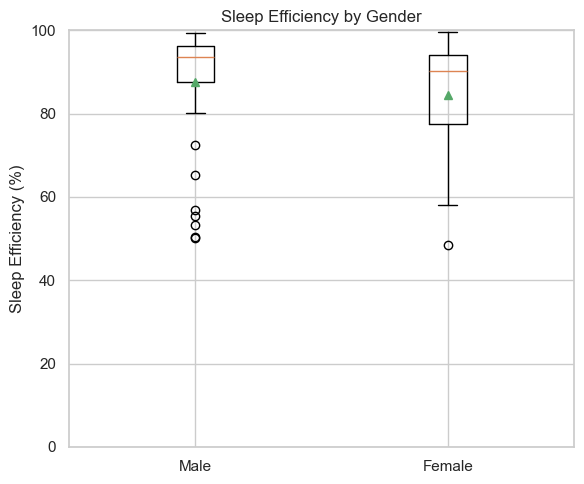

In [52]:
vals = [df.loc[df['sex']=='Male', 'Sleep_Efficiency_%'].dropna().values,
        df.loc[df['sex']=='Female','Sleep_Efficiency_%'].dropna().values]

plt.figure(figsize=(6,5))
plt.boxplot(vals, labels=['Male','Female'], showmeans=True)
plt.title('Sleep Efficiency by Gender')
plt.ylabel('Sleep Efficiency (%)')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/1756519830.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, labels=['<40','40–59','≥60'], showmeans=True)


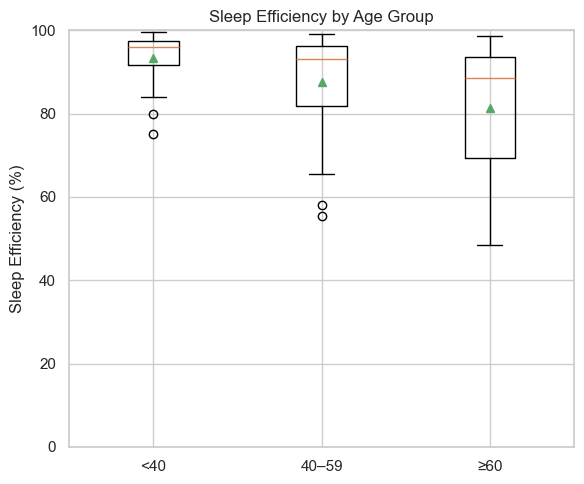

In [54]:
vals = [df.loc[df['age_group']=='<40',  'Sleep_Efficiency_%'].dropna().values,
        df.loc[df['age_group']=='40–59','Sleep_Efficiency_%'].dropna().values,
        df.loc[df['age_group']=='≥60',  'Sleep_Efficiency_%'].dropna().values]

plt.figure(figsize=(6,5))
plt.boxplot(vals, labels=['<40','40–59','≥60'], showmeans=True)
plt.title('Sleep Efficiency by Age Group')
plt.ylabel('Sleep Efficiency (%)')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


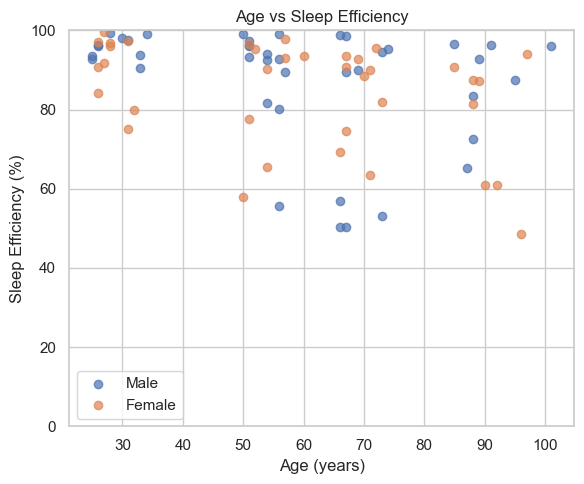

In [56]:
plt.figure(figsize=(6,5))

mask_m = df['sex']=='Male'
mask_f = df['sex']=='Female'

plt.scatter(df.loc[mask_m,'age'], df.loc[mask_m,'Sleep_Efficiency_%'], label='Male', alpha=0.7)
plt.scatter(df.loc[mask_f,'age'], df.loc[mask_f,'Sleep_Efficiency_%'], label='Female', alpha=0.7)

plt.title('Age vs Sleep Efficiency')
plt.xlabel('Age (years)')
plt.ylabel('Sleep Efficiency (%)')
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()


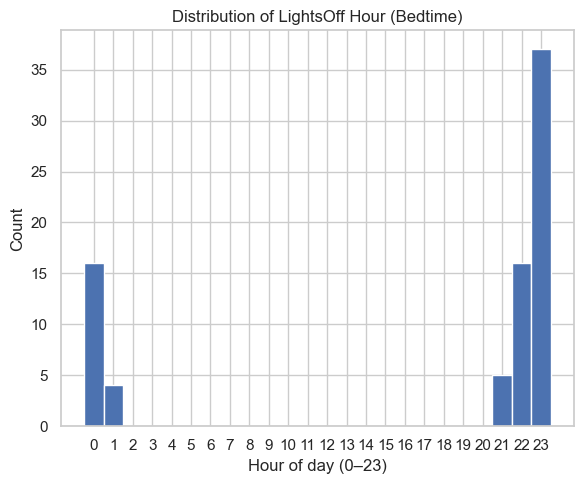

In [58]:
plt.figure(figsize=(6,5))
vals = df['LightsOff_hour'].dropna().astype(int).values
plt.hist(vals, bins=np.arange(-0.5, 24.5, 1))
plt.title('Distribution of LightsOff Hour (Bedtime)')
plt.xlabel('Hour of day (0–23)')
plt.ylabel('Count')
plt.xticks(range(0,24,1))
plt.tight_layout()
plt.show()


## Statistical Testing

To determine whether differences in sleep metrics between demographic groups are statistically significant, hypothesis testing was performed.

### Tests Performed
1. **Independent Samples t-test**
   - Compared mean Sleep Efficiency between males and females.
   - Assumption of equal variances tested using Levene's test.

2. **One-way ANOVA**
   - Compared mean Sleep Efficiency across three age groups: `<40`, `40–59`, `≥60`.
   - Follow-up pairwise comparisons performed using Tukey's HSD test.

### Hypotheses
- **t-test:**
  - Null Hypothesis (H₀): No difference in mean Sleep Efficiency between males and females.
  - Alternative Hypothesis (H₁): Mean Sleep Efficiency differs by gender.
- **ANOVA:**
  - Null Hypothesis (H₀): All age groups have the same mean Sleep Efficiency.
  - Alternative Hypothesis (H₁): At least one age group has a different mean Sleep Efficiency.

### Significance Level
- Tests performed at α = 0.05.

Results of these tests help determine whether observed differences in the descriptive statistics are statistically meaningful.


In [61]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Prepare data
df = merged.copy()
df['age_group'] = pd.cut(df['age'], bins=[0, 39, 59, 120], labels=['<40', '40–59', '≥60'], right=True)

# --- 1. Independent t-test: SE by gender ---
male_se = df.loc[df['sex'] == 'Male', 'Sleep_Efficiency_%'].dropna()
female_se = df.loc[df['sex'] == 'Female', 'Sleep_Efficiency_%'].dropna()

# Levene's test for equal variances
levene_stat, levene_p = stats.levene(male_se, female_se)
print(f"Levene's test p-value: {levene_p:.4f}")

# Choose t-test type based on variance equality
equal_var = levene_p > 0.05
t_stat, t_p = stats.ttest_ind(male_se, female_se, equal_var=equal_var)
print(f"T-test p-value (gender): {t_p:.4f}")

# --- 2. One-way ANOVA: SE by age group ---
anova_model = ols('Q("Sleep_Efficiency_%") ~ C(age_group)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print("\nANOVA results:\n", anova_table)

# --- 3. Tukey HSD for pairwise age group comparisons ---
tukey = pairwise_tukeyhsd(endog=df['Sleep_Efficiency_%'], groups=df['age_group'], alpha=0.05)
print("\nTukey HSD results:\n", tukey)


Levene's test p-value: 0.7765
T-test p-value (gender): 0.3410

ANOVA results:
                     sum_sq    df         F    PR(>F)
C(age_group)   1897.277347   2.0  5.259245  0.007287
Residual      13528.158649  75.0       NaN       NaN

Tukey HSD results:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
 40–59    <40   5.5936 0.3815    -4.44 15.6272  False
 40–59    ≥60  -6.2755 0.2081 -15.0494  2.4984  False
   <40    ≥60 -11.8691 0.0059 -20.7818 -2.9563   True
-----------------------------------------------------


## Statistical Test Results

### 1. Gender Differences in Sleep Efficiency
- **Levene's test for equality of variances**: p = 0.7765  
  → Variances between male and female groups are not significantly different; t-test assumption holds.
- **Independent samples t-test**: p = 0.3410  
  → No statistically significant difference in mean Sleep Efficiency between males and females at α = 0.05.

### 2. Age Group Differences in Sleep Efficiency
- **One-way ANOVA**: F(2, 75) = 5.259, p = 0.0073  
  → There is a statistically significant difference in mean Sleep Efficiency among the three age groups (`<40`, `40–59`, `≥60`).

### 3. Post-hoc Tukey's HSD Test
- **40–59 vs <40**: p = 0.3815 → Not significant  
- **40–59 vs ≥60**: p = 0.2081 → Not significant  
- **<40 vs ≥60**: p = 0.0059 → Significant  
  → Participants under 40 years old have a significantly higher mean Sleep Efficiency compared to those aged 60 and above.

### Summary Interpretation
- **Gender** does not appear to influence Sleep Efficiency in this sample.
- **Age** has a significant effect on Sleep Efficiency, with the largest difference observed between the youngest (`<40`) and oldest (`≥60`) participants.
- Middle-aged participants (`40–59`) do not differ significantly from either younger or older groups.


In [66]:
# !pip install mne torch torcheval
import os, glob, numpy as np, mne, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Counter

########################################
# 1) DATA PREP: PSG -> 30s epochs + labels
########################################

# Map SHHS annotation text to class ids
STAGE_MAP = {
    'Sleep stage W': 0, 'Sleep stage 1': 1, 'Sleep stage 2': 2,
    'Sleep stage 3': 3, 'Sleep stage 4': 3, 'Sleep stage R': 4
}
CLASSES = ['W','N1','N2','N3','REM']

def load_epochs(psg_path, hyp_path, sfreq=100, epoch_sec=30,
                eeg_names=('EEG(sec)',), eog_names=('EOG(L)','EOG(R)'), emg_names=('EMG','EMG1','EMG2')):
    """Return X (n_epochs, C, T) and y (n_epochs,) from a single night."""
    # Load signals
    raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
    ann = mne.read_annotations(hyp_path)
    raw.set_annotations(ann)

    # Pick a small channel set (fallbacks allowed)
    picks = []
    for name in list(eeg_names)+list(eog_names)+list(emg_names):
        if name in raw.ch_names: picks.append(name)
    if not picks: raise RuntimeError("No requested channels found.")
    raw.pick(picks)
    raw.load_data()

    # Basic filtering (light)
    raw.filter(l_freq=0.3, h_freq=35.0, verbose=False)
    raw.resample(sfreq, npad="auto")

    # Build per-epoch labels from annotations
    epoch_len = int(epoch_sec * sfreq)
    total_samples = len(raw.times)
    n_epochs = total_samples // epoch_len
    if n_epochs == 0: raise RuntimeError("Recording too short.")

    # Create label timeline (sample-wise); default -1 (unlabeled)
    lab = -1 * np.ones(total_samples, dtype=np.int16)
    on, dur, desc = np.array(raw.annotations.onset), np.array(raw.annotations.duration), np.array(raw.annotations.description)
    # Convert onsets,durations (sec) to samples
    for o, d, de in zip(on, dur, desc):
        if de in STAGE_MAP:
            s0 = max(0, int(o * sfreq))
            s1 = min(total_samples, int((o + d) * sfreq))
            lab[s0:s1] = STAGE_MAP[de]

    # Slice into epochs where label is known (majority vote per epoch)
    data = raw.get_data()  # shape (C, T)
    X, y = [], []
    for i in range(n_epochs):
        a, b = i*epoch_len, (i+1)*epoch_len
        seg = data[:, a:b]
        seg_lab = lab[a:b]
        valid = seg_lab[seg_lab >= 0]
        if len(valid) == 0: continue
        # majority label in the epoch
        mlabel = Counter(valid.tolist()).most_common(1)[0][0]
        X.append(seg.astype(np.float32))
        y.append(int(mlabel))

    if not X: raise RuntimeError("No labeled epochs found.")
    X = np.stack(X)                 # (N, C, T)
    y = np.array(y, dtype=np.int64) # (N,)
    return X, y, picks, sfreq

########################################
# 2) DATASET / DATALOADER
########################################
class SleepEpochsDS(Dataset):
    def __init__(self, X, y, augment=False):
        self.X, self.y, self.augment = X, y, augment
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        x = self.X[i]
        if self.augment:
            # light jitter + scaling
            x = x + 0.01*np.random.randn(*x.shape).astype(np.float32)
            x = x * (0.9 + 0.2*np.random.rand()).astype(np.float32)
        return torch.from_numpy(x), torch.tensor(self.y[i])

########################################
# 3) MODEL: 1D CNN + BiLSTM (tiny but effective)
########################################
class StageNet(nn.Module):
    def __init__(self, C, T, n_classes=5, lstm_hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(C, 32, 7, padding=3), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding=3), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding=3), nn.ReLU(), nn.MaxPool1d(2),
        )
        # compute downsampled length
        L = T // 8
        self.lstm = nn.LSTM(input_size=128, hidden_size=lstm_hidden,
                            num_layers=1, batch_first=True, bidirectional=True)
        self.head = nn.Sequential(
            nn.Linear(2*lstm_hidden, 128), nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, n_classes)
        )
    def forward(self, x):
        # x: (B, C, T)
        z = self.net(x)            # (B, 128, L)
        z = z.transpose(1, 2)      # (B, L, 128)
        z, _ = self.lstm(z)        # (B, L, 2H)
        z = z.mean(dim=1)          # temporal pooling
        return self.head(z)

########################################
# 4) TRAIN / EVAL
########################################
def train_one_model(train_dl, val_dl, C, T, class_weights=None, epochs=10, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = StageNet(C, T).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device) if class_weights is not None else None)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_val = -1; best = None

    for ep in range(1, epochs+1):
        model.train(); tr_loss=0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(); logits = model(xb)
            loss = criterion(logits, yb); loss.backward(); opt.step()
            tr_loss += loss.item()*len(yb)
        # eval
        model.eval(); correct=0; total=0; all_pred=[]; all_true=[]
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                pred = logits.argmax(1)
                correct += (pred==yb).sum().item(); total += len(yb)
                all_pred.extend(pred.cpu().numpy()); all_true.extend(yb.cpu().numpy())
        acc = correct/total
        print(f"Epoch {ep:02d}: loss={tr_loss/len(train_dl.dataset):.4f}  val_acc={acc:.3f}")
        if acc>best_val: best_val=acc; best = {'state':model.state_dict(), 'acc':acc}
    model.load_state_dict(best['state'])
    return model, best_val

########################################
# 5) PUT IT TOGETHER ON YOUR DATA
########################################
# Point to one subject first (then loop over many for train/val split)
data_folder = 'data/sleep-cassette'
psg = os.path.join(data_folder, 'SC4001E0-PSG.edf')         # <-- replace with actual
hyp = os.path.join(data_folder, 'SC4001EC-Hypnogram.edf')   # <-- replace with actual

X, y, picks, fs = load_epochs(psg, hyp, sfreq=100, epoch_sec=30)
print("Shape:", X.shape, "Channels:", picks, "fs:", fs)

# Train/val split by epoch (for a quick demo)
rng = np.random.default_rng(0)
idx = rng.permutation(len(y))
n_tr = int(0.8*len(y))
tr_idx, va_idx = idx[:n_tr], idx[n_tr:]
Xtr, Ytr = X[tr_idx], y[tr_idx]; Xva, Yva = X[va_idx], y[va_idx]

train_ds = SleepEpochsDS(Xtr, Ytr, augment=True)
val_ds   = SleepEpochsDS(Xva, Yva, augment=False)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
val_dl   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=0)

# Class weights to handle imbalance (optional but helpful)
counts = np.bincount(Ytr, minlength=5); inv = 1/(counts+1e-6); w = torch.tensor(inv/inv.sum()*5, dtype=torch.float32)

model, best_val = train_one_model(train_dl, val_dl, C=X.shape[1], T=X.shape[2], class_weights=w, epochs=10, lr=1e-3)
print("Best val acc:", best_val)

# Inference on new epochs
def predict_epochs(model, X):
    model.eval()
    with torch.no_grad():
        logits = model(torch.from_numpy(X).float().to(next(model.parameters()).device))
        return logits.softmax(1).cpu().numpy().argmax(1)

preds = predict_epochs(model, Xva[:128])
print("Pred sample:", preds[:20])


/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/529962545.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/529962545.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/529962545.py:21: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/529962545.py:23: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(ann)


RuntimeError: No requested channels found.

In [68]:
raw = mne.io.read_raw_edf(psg_path, preload=False)
print(raw.ch_names)


Extracting EDF parameters from /Users/mook/S777/T2:2025/Project_B/use_case/data/sleep-cassette/SC4292G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']


/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/3009473429.py:1: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/3009473429.py:1: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=False)
/var/folders/62/b0dk11115_5cl1s5_xvm9_vw0000gn/T/ipykernel_16320/3009473429.py:1: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=False)


In [ ]:
# ====== INSTALL (once) ======
# pip install mne torch torcheval statsmodels

import os, glob, re, numpy as np, mne, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.model_selection import train_test_split
import mne, warnings
mne.set_log_level('WARNING')    # or 'ERROR'
warnings.filterwarnings("ignore", category=RuntimeWarning)

DATA_DIR = "data/sleep-cassette"  # <-- change if needed

# ---------- 0) Utilities ----------
STAGE_MAP = {
    'Sleep stage W': 0, 'Sleep stage 1': 1, 'Sleep stage 2': 2,
    'Sleep stage 3': 3, 'Sleep stage 4': 3, 'Sleep stage R': 4
}
CLASSES = ['W','N1','N2','N3','REM']

def find_pairs(data_dir=DATA_DIR):
    """Return list of (psg_path, hyp_path, subject_base) pairs."""
    psgs = sorted(glob.glob(os.path.join(data_dir, "*-PSG.edf")))
    pairs = []
    for p in psgs:
        full = os.path.basename(p).split("-")[0]        # e.g., SC4292G0
        base = full[:6]                                  # e.g., SC4292
        hyp_matches = glob.glob(os.path.join(data_dir, f"{full}-Hypnogram.edf"))
        if not hyp_matches:
            # try any suffix for same base (EC/EH/EJ/EP/G0/…)
            hyp_matches = glob.glob(os.path.join(data_dir, f"{base}E*-Hypnogram.edf"))
            hyp_matches += glob.glob(os.path.join(data_dir, f"{base}G*-Hypnogram.edf"))
        if hyp_matches:
            pairs.append((p, hyp_matches[0], base))
    return pairs

def pick_shhs_channels(raw):
    picks = []
    for want in ['EEG Fpz-Cz', 'EOG horizontal', 'EMG submental']:
        if want in raw.ch_names: picks.append(want)
    if not picks:
        raise RuntimeError(f"No required channels found. Available: {raw.ch_names}")
    raw.pick(picks)
    return picks

def load_epochs(psg_path, hyp_path, sfreq=100, epoch_sec=10):
    """Return X (N,C,T) float32 and y (N,) int64 for one night."""
    raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
    ann = mne.read_annotations(hyp_path)
    raw.set_annotations(ann)

    # pick channels
    picks = pick_shhs_channels(raw)

    # light filtering & resample
    raw.filter(l_freq=0.3, h_freq=35.0, verbose=False)
    raw.resample(sfreq, npad="auto")

    # annotation label timeline
    total_samples = len(raw.times)
    lab = -1 * np.ones(total_samples, dtype=np.int16)
    on, dur, desc = np.array(raw.annotations.onset), np.array(raw.annotations.duration), np.array(raw.annotations.description)
    for o, d, de in zip(on, dur, desc):
        if de in STAGE_MAP:
            s0 = max(0, int(o * sfreq))
            s1 = min(total_samples, int((o + d) * sfreq))
            lab[s0:s1] = STAGE_MAP[de]

    # slice into 30s epochs, majority label per epoch
    epoch_len = int(epoch_sec * sfreq)
    n_epochs = total_samples // epoch_len
    data = raw.get_data()  # (C,T)
    X, y = [], []
    for i in range(n_epochs):
        a, b = i*epoch_len, (i+1)*epoch_len
        seg_lab = lab[a:b]
        valid = seg_lab[seg_lab >= 0]
        if len(valid) == 0: continue
        mlabel = Counter(valid.tolist()).most_common(1)[0][0]
        X.append(data[:, a:b].astype(np.float32))
        y.append(int(mlabel))
    if not X: raise RuntimeError("No labeled epochs found.")
    return np.stack(X), np.array(y, dtype=np.int64), picks, sfreq

# ---------- 1) Build subject-wise dataset ----------
pairs = find_pairs(DATA_DIR)
subjects = sorted({base for _,_,base in pairs})
train_subj, test_subj = train_test_split(subjects, test_size=0.2, random_state=42)
train_subj, val_subj  = train_test_split(train_subj, test_size=0.2, random_state=42)

def collect(subj_set):
    Xs, ys = [], []
    for psg, hyp, base in pairs:
        if base not in subj_set: continue
        try:
            X, y, picks, fs = load_epochs(psg, hyp, sfreq=100, epoch_sec=10)
            Xs.append(X); ys.append(y)
        except Exception as e:
            print(f"[Skip] {os.path.basename(psg)}: {e}")
    if not Xs: raise RuntimeError("No data collected. Check file paths.")
    return np.concatenate(Xs, axis=0), np.concatenate(ys, axis=0)

Xtr, Ytr = collect(train_subj)
Xva, Yva = collect(val_subj)
Xte, Yte = collect(test_subj)

C, T = Xtr.shape[1], Xtr.shape[2]
print("Train:", Xtr.shape, "Val:", Xva.shape, "Test:", Xte.shape, "| Channels:", C, "Samples/epoch:", T)

# ---------- 2) PyTorch Dataset ----------
class SleepDS(Dataset):
    def __init__(self, X, y, augment=False):
        self.X, self.y, self.augment = X, y, augment
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        x = self.X[i]
        if self.augment:
            # light jitter + scaling
            x = x + 0.01*np.random.randn(*x.shape).astype(np.float32)
            x = x * np.float32(0.9 + 0.2*np.random.rand())
        return torch.from_numpy(x), torch.tensor(self.y[i])


tr_ds = SleepDS(Xtr, Ytr, augment=True)
va_ds = SleepDS(Xva, Yva, augment=False)
te_ds = SleepDS(Xte, Yte, augment=False)

tr_dl = DataLoader(tr_ds, batch_size=64, shuffle=True,  num_workers=0)
va_dl = DataLoader(va_ds, batch_size=64, shuffle=False, num_workers=0)
te_dl = DataLoader(te_ds, batch_size=64, shuffle=False, num_workers=0)

# ---------- 3) Model ----------
class StageNet(nn.Module):
    def __init__(self, C, T, n_classes=5, lstm_hidden=128):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(C, 32, 7, padding=3), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(32,64, 7, padding=3), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(64,128,7, padding=3), nn.ReLU(), nn.MaxPool1d(2),
        )
        L = T // 8
        self.lstm = nn.LSTM(128, lstm_hidden, batch_first=True, bidirectional=True)
        self.head = nn.Sequential(
            nn.Linear(2*lstm_hidden, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, n_classes)
        )
    def forward(self, x):
        z = self.cnn(x)          # (B,128,L)
        z = z.transpose(1, 2)    # (B,L,128)
        z, _ = self.lstm(z)      # (B,L,2H)
        z = z.mean(1)            # (B,2H)
        return self.head(z)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = StageNet(C, T).to(device)

# Class weights (handle imbalance)
counts = np.bincount(Ytr, minlength=5)
w = torch.tensor((1.0/(counts+1e-6))*(5/np.sum(1.0/(counts+1e-6))), dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=w)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# ---------- 4) Train ----------
def eval_loader(dl):
    model.eval(); correct=0; total=0
    with torch.no_grad():
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(1)
            correct += (pred==yb).sum().item()
            total   += len(yb)
    return correct/total

best_acc, best_state = -1, None
for ep in range(1, 5):
    model.train(); tr_loss=0
    for xb, yb in tr_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward(); opt.step()
        tr_loss += loss.item()*len(yb)
    va_acc = eval_loader(va_dl)
    print(f"Epoch {ep:02d} | train_loss={tr_loss/len(tr_ds):.4f} | val_acc={va_acc:.3f}")
    if va_acc > best_acc:
        best_acc = va_acc; best_state = {k:v.cpu() for k,v in model.state_dict().items()}

model.load_state_dict({k:v.to(device) for k,v in best_state.items()})
test_acc = eval_loader(te_dl)
print("Best Val Acc:", best_acc, " | Test Acc:", test_acc)

# ---------- 5) Predict on test sample ----------
model.eval()
with torch.no_grad():
    xb, yb = next(iter(te_dl))
    xb = xb.to(device)
    probs = model(xb).softmax(1).cpu().numpy()
preds = probs.argmax(1)
print("Pred classes sample:", preds[:20], "| True:", yb[:20].numpy())


Train: (621897, 3, 1000) Val: (165471, 3, 1000) Test: (202029, 3, 1000) | Channels: 3 Samples/epoch: 1000
Epoch 01 | train_loss=1.6093 | val_acc=0.667
